In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, 
    roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import pickle
from enum import Enum
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix, hstack
import os
os.chdir("D:/Users/Jose Castro/Desktop/FINAL NO COUNTRY/c21-47-ft-data-bi")

In [2]:
class SamplingMethod(Enum):
    UNDERSAMPLING = 1
    NONE = 3

In [3]:
def plot_class_distribution(y, title='Distribución de Clases'):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel('Clase')
    plt.ylabel('Frecuencia')
    plt.xticks(ticks=[0, 1], labels=['No Fraud', 'Fraud'])
    plt.show()

In [4]:
def plot_confusion_matrix(cm, title='Matriz de Confusión', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Fraud', 'Fraud'], rotation=45)
    plt.yticks(tick_marks, ['No Fraud', 'Fraud'])

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.tight_layout()

In [5]:
def plot_roc_curve(fpr, tpr, auc, title='Curva ROC'):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (Área = {:.2f})'.format(auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()

In [6]:
def print_results(results, model_name, balance_type, random_seed):
    if isinstance(results, tuple) and len(results) == 7:
        accuracy, precision, recall, f1, roc_auc, best_params, model = results
        print(f"  {model_name} - {balance_type} (Semilla {random_seed})")
        print(f"    Accuracy: {accuracy}")
        print(f"    Precision: {precision}")
        print(f"    Recall: {recall}")
        print(f"    F1 Score: {f1}")
        print(f"    ROC-AUC: {roc_auc}")
        print(f"    Best Parameters: {best_params}")

        # Guardar el modelo entrenado
        model_filename = f"model_kmeans_{model_name}_{balance_type}_seed_{random_seed}.pkl"
        with open(model_filename, "wb") as file:
            pickle.dump(model, file)
        print(f"Modelo guardado como {model_filename}")
    else:
        print(f"Formato desconocido de resultados para {model_name} - {balance_type} (Semilla {random_seed})")


In [7]:
def grid_search_with_and_without_balance(model, param_grid, X_train, y_train, X_eval, y_eval, X_test, y_test, sampler=None, random_seed=None, balance_type=None):
    """
    Optimiza los hiperparámetros de un modelo con opciones para balancear las clases.
    """
    print(f"\n--> Iniciando {balance_type} para {model.__class__.__name__} con semilla {random_seed}")

    # Aplicar balanceo solo si el modelo no admite scale_pos_weight
    if balance_type == 'undersampling' and sampler == SamplingMethod.UNDERSAMPLING:
        sampler = RandomUnderSampler(random_state=random_seed)
        print(f"Tamaño original de X_train: {X_train.shape}, y_train: {y_train.shape}")
        plot_class_distribution(y_train, title='Distribución de Clases - Antes de Undersampling')
        X_train, y_train = sampler.fit_resample(X_train, y_train)
        print(f"Tamaño después de undersampling de X_train: {X_train.shape}, y_train: {y_train.shape}")
        plot_class_distribution(y_train, title='Distribución de Clases - Después de Undersampling')

    # Realizar la búsqueda en cuadrícula
    grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=5)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    # Ajustar el modelo con los mejores parámetros
    model.set_params(**best_params)
    model.fit(X_train, y_train)

    # Evaluación en el conjunto de validación
    print(f"\nEvaluación en el conjunto de validación para {model.__class__.__name__} - Semilla {random_seed}")
    y_val_pred = model.predict(X_eval)
    y_val_pred_prob = model.predict_proba(X_eval)[:, 1]
    val_accuracy = accuracy_score(y_eval, y_val_pred)
    val_precision = precision_score(y_eval, y_val_pred)
    val_recall = recall_score(y_eval, y_val_pred)
    val_f1 = f1_score(y_eval, y_val_pred)
    val_roc_auc = roc_auc_score(y_eval, y_val_pred)

    print_results((val_accuracy, val_precision, val_recall, val_f1, val_roc_auc, best_params, model), model.__class__.__name__, balance_type, random_seed)
    cm = confusion_matrix(y_eval, y_val_pred)
    plot_confusion_matrix(cm, title=f'Matriz de Confusión - Validación - {model.__class__.__name__} - Semilla {random_seed}')
    fpr, tpr, _ = roc_curve(y_eval, y_val_pred_prob)
    plot_roc_curve(fpr, tpr, val_roc_auc, title=f'Curva ROC - Validación - {model.__class__.__name__} - Semilla {random_seed}')
    plt.show()

    # Evaluación final en el conjunto de prueba
    print(f"\nEvaluación final en el conjunto de prueba para {model.__class__.__name__} - Semilla {random_seed}")
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    test_roc_auc = roc_auc_score(y_test, y_pred)

    print_results((test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, best_params, model), model.__class__.__name__, balance_type, random_seed)
    cm_test = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm_test, title=f'Matriz de Confusión - Prueba - {model.__class__.__name__} - Semilla {random_seed}')
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob)
    plot_roc_curve(fpr_test, tpr_test, test_roc_auc, title=f'Curva ROC - Prueba - {model.__class__.__name__} - Semilla {random_seed}')
    plt.show()

    return test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, best_params, model


In [8]:
url= "data\intermediate\data_final_0"

data = pd.read_feather(url)
data_copy = data.copy()

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Jose Castro\AppData\Local\Temp\ipykernel_30656\3553701664.py:1: SyntaxWarning: invalid escape sequence '\i'
  url= "data\intermediate\data_final_0"


In [9]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 5 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   amt                     1296675 non-null  float64
 1   amount_per_transaction  1296675 non-null  float64
 2   age_amount_interaction  1296675 non-null  float64
 3   job_encoded             1296675 non-null  float64
 4   is_fraud                1296675 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 49.5 MB


In [10]:
features = data_copy.drop(["is_fraud"], axis=1)
target = data_copy.is_fraud

In [11]:
numeric_features = features.select_dtypes(include=['number']).columns.tolist()
categorical_features = features.select_dtypes(include=['object']).columns.tolist()

In [12]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [13]:
results_by_seed = {}
models_by_seed = {}
seed_list = [42,15,1235,10101101]  # Puedes agregar más semillas aquí

best_global_f1 = -1
best_global_model = None
best_global_approach = None
best_global_seed = None
best_global_params = None
best_models_by_approach = {
    #'weighted': {'model': None, 'params': None, 'f1': -1},
    'undersampling': {'model': None, 'params': None, 'f1': -1}
    #'oversampling': {'model': None, 'params': None, 'f1': -1},
    #'unbalanced': {'model': None, 'params': None, 'f1': -1}
}

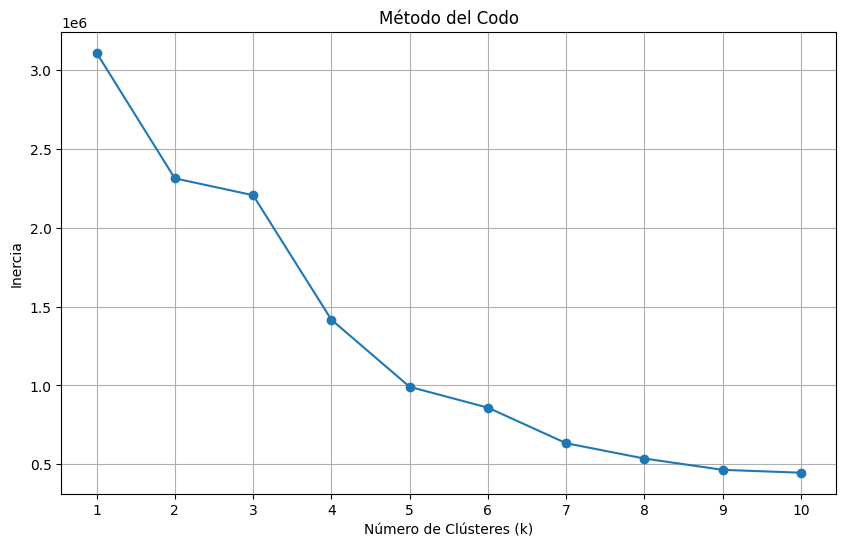


--> Iniciando undersampling para LogisticRegression con semilla 42
Tamaño original de X_train: (778005, 5), y_train: (778005,)


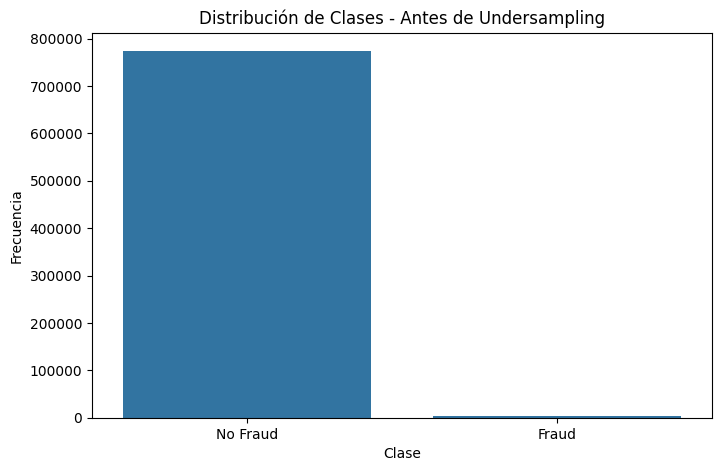

Tamaño después de undersampling de X_train: (8894, 5), y_train: (8894,)


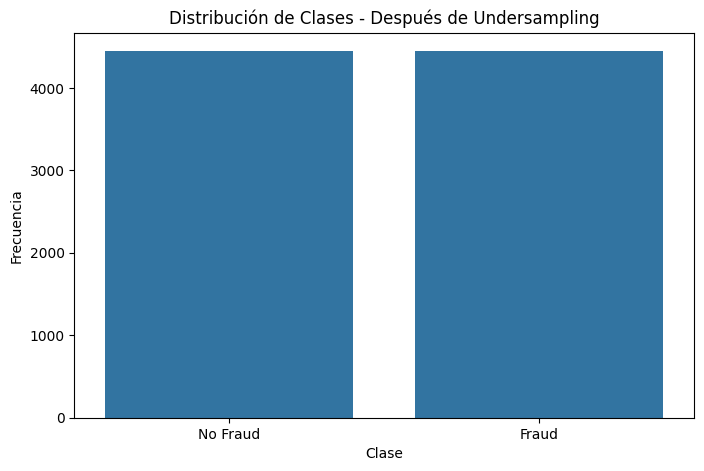


Evaluación en el conjunto de validación para LogisticRegression - Semilla 42
  LogisticRegression - undersampling (Semilla 42)
    Accuracy: 0.9516648350589006
    Precision: 0.08927237412221724
    Recall: 0.7764782326185835
    F1 Score: 0.16013400335008376
    ROC-AUC: 0.8645944515355948
    Best Parameters: {'C': 10}
Modelo guardado como model_kmeans_LogisticRegression_undersampling_seed_42.pkl


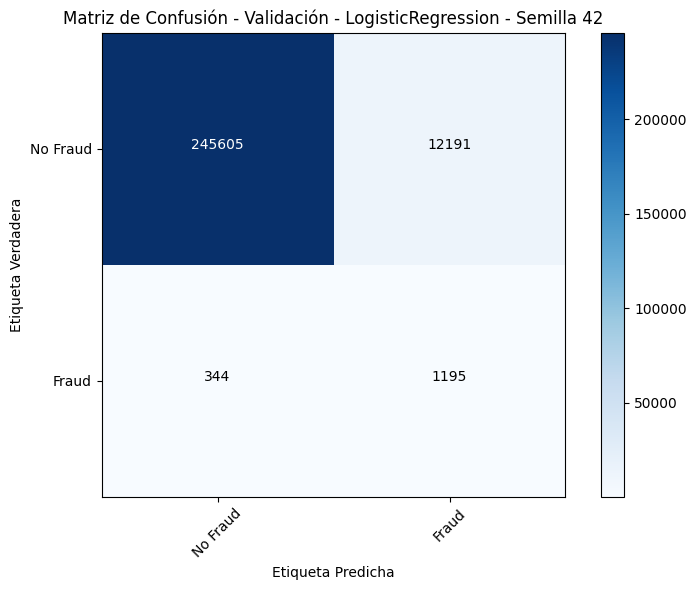

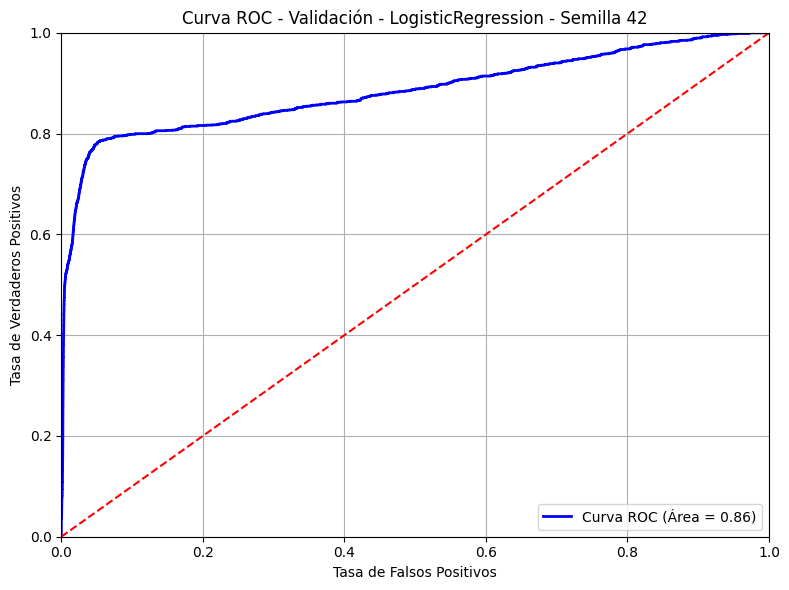


Evaluación final en el conjunto de prueba para LogisticRegression - Semilla 42
  LogisticRegression - undersampling (Semilla 42)
    Accuracy: 0.950562014382941
    Precision: 0.08680073126142596
    Recall: 0.780921052631579
    F1 Score: 0.15623560381704507
    ROC-AUC: 0.8662416096507389
    Best Parameters: {'C': 10}
Modelo guardado como model_kmeans_LogisticRegression_undersampling_seed_42.pkl


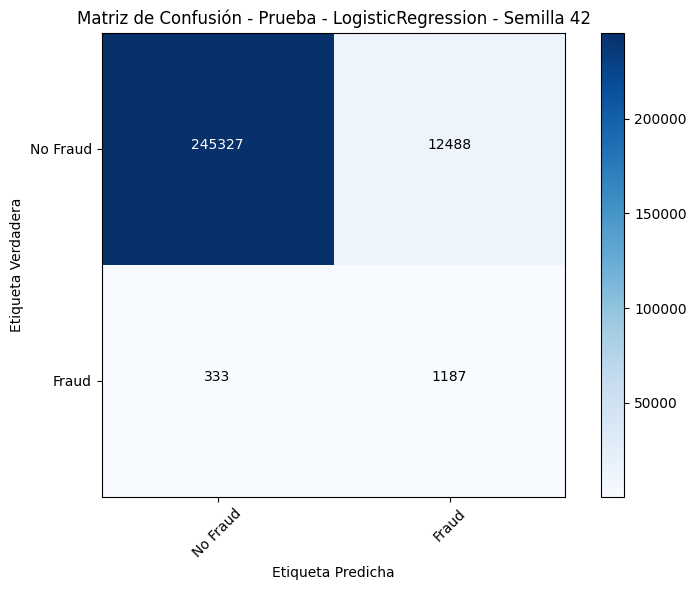

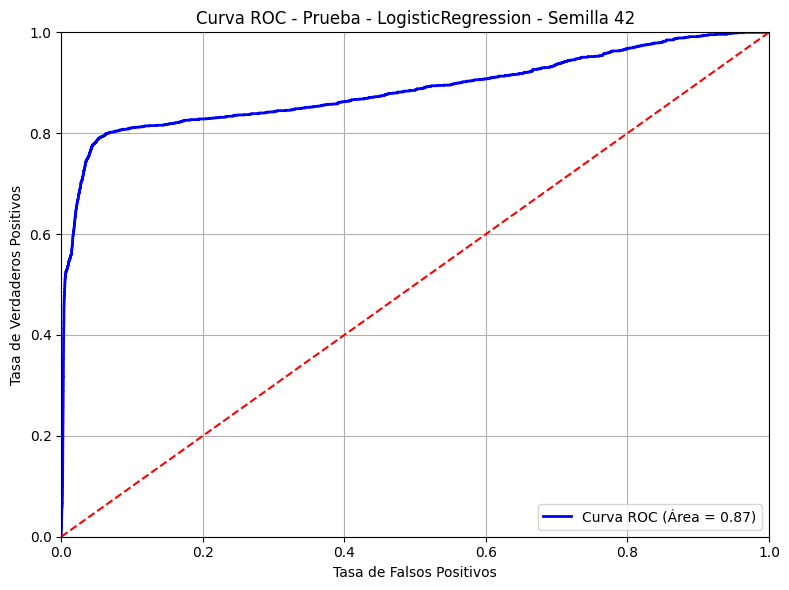

  LogisticRegression - undersampling (Semilla 42)
    Accuracy: 0.950562014382941
    Precision: 0.08680073126142596
    Recall: 0.780921052631579
    F1 Score: 0.15623560381704507
    ROC-AUC: 0.8662416096507389
    Best Parameters: {'C': 10}
Modelo guardado como model_kmeans_LogisticRegression_undersampling_seed_42.pkl

--> Iniciando undersampling para DecisionTreeClassifier con semilla 42
Tamaño original de X_train: (778005, 5), y_train: (778005,)


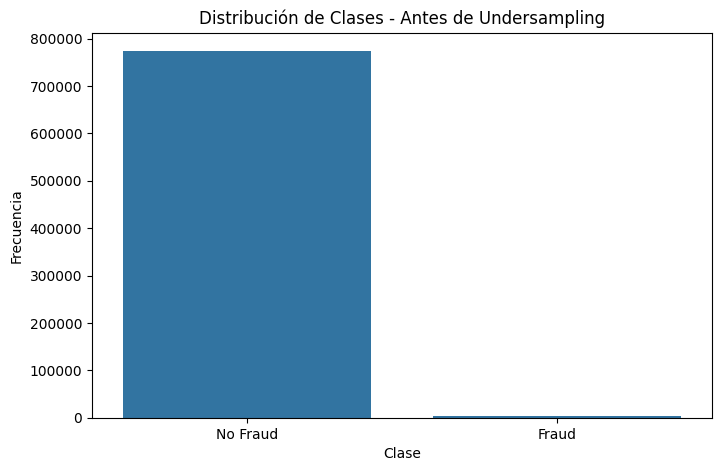

Tamaño después de undersampling de X_train: (8894, 5), y_train: (8894,)


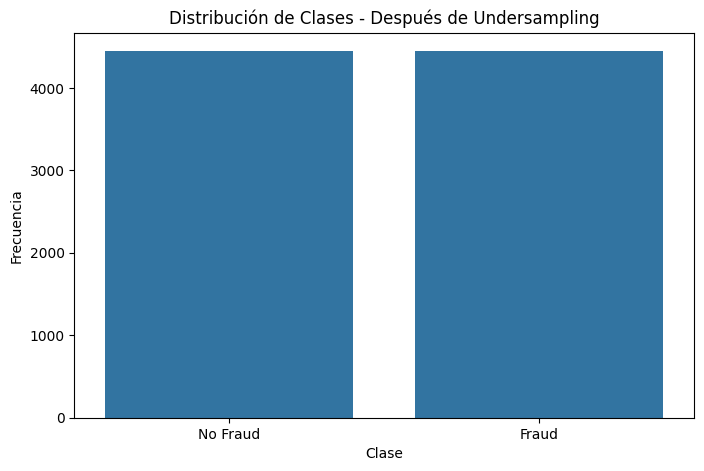


Evaluación en el conjunto de validación para DecisionTreeClassifier - Semilla 42
  DecisionTreeClassifier - undersampling (Semilla 42)
    Accuracy: 0.9076445524129022
    Precision: 0.05336787564766839
    Recall: 0.8700454840805718
    F1 Score: 0.10056705095948026
    ROC-AUC: 0.8889572483941471
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Modelo guardado como model_kmeans_DecisionTreeClassifier_undersampling_seed_42.pkl


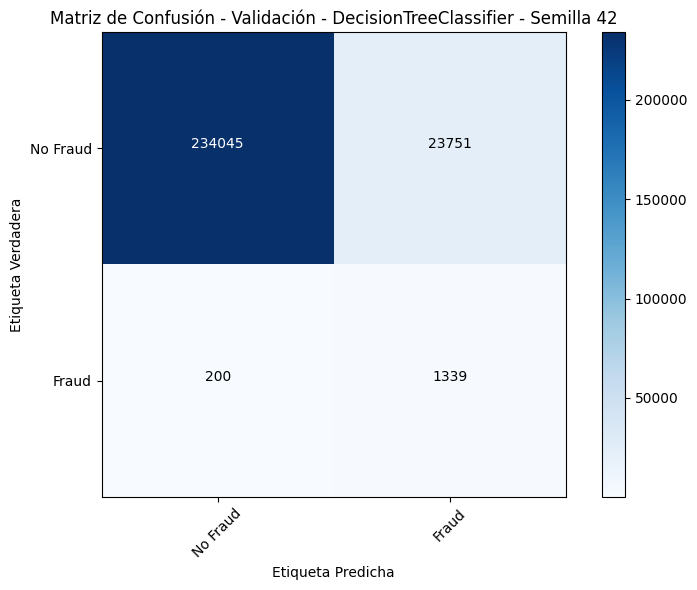

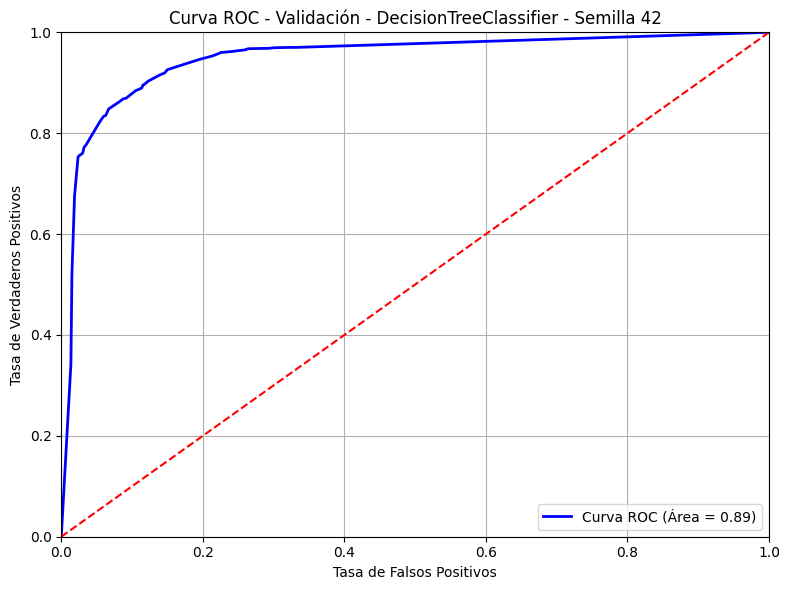


Evaluación final en el conjunto de prueba para DecisionTreeClassifier - Semilla 42
  DecisionTreeClassifier - undersampling (Semilla 42)
    Accuracy: 0.9070121657315827
    Precision: 0.05308754301989794
    Recall: 0.8828947368421053
    F1 Score: 0.10015299078323818
    ROC-AUC: 0.8950245458544837
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Modelo guardado como model_kmeans_DecisionTreeClassifier_undersampling_seed_42.pkl


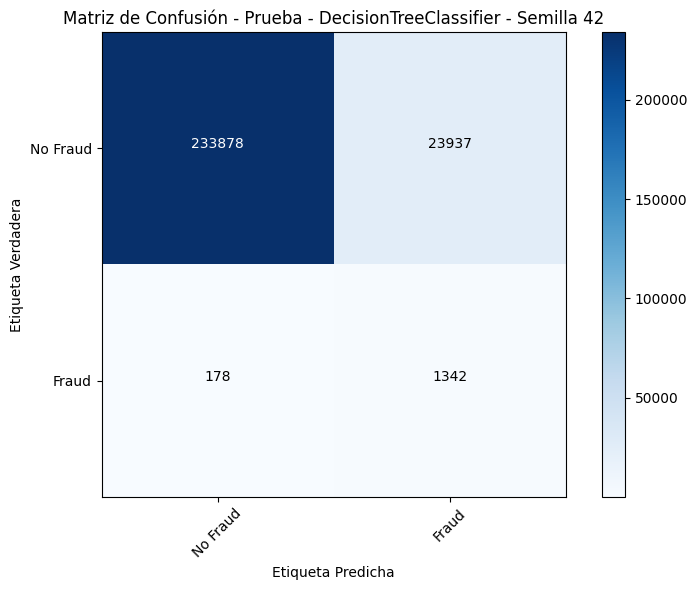

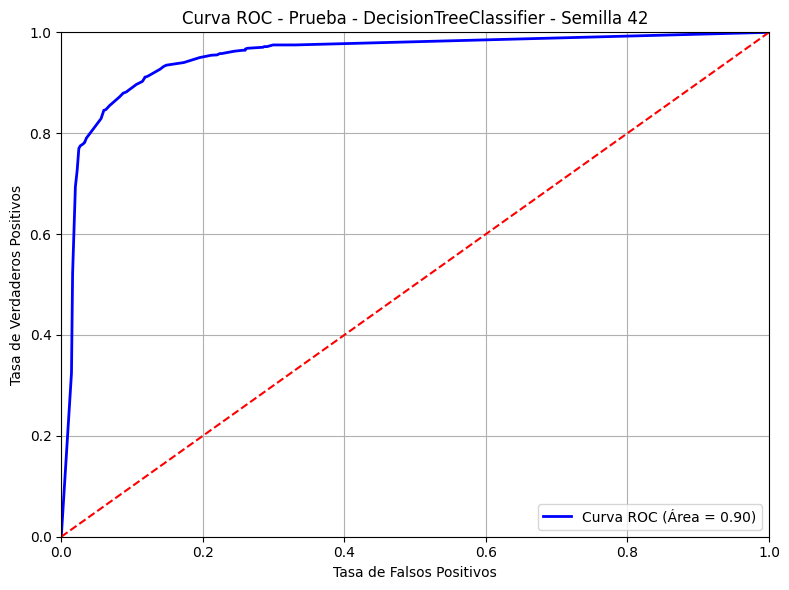

  DecisionTreeClassifier - undersampling (Semilla 42)
    Accuracy: 0.9070121657315827
    Precision: 0.05308754301989794
    Recall: 0.8828947368421053
    F1 Score: 0.10015299078323818
    ROC-AUC: 0.8950245458544837
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Modelo guardado como model_kmeans_DecisionTreeClassifier_undersampling_seed_42.pkl

--> Iniciando undersampling para RandomForestClassifier con semilla 42
Tamaño original de X_train: (778005, 5), y_train: (778005,)


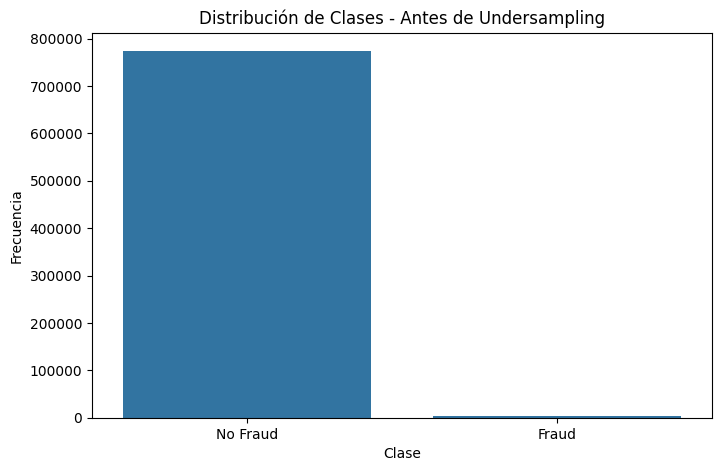

Tamaño después de undersampling de X_train: (8894, 5), y_train: (8894,)


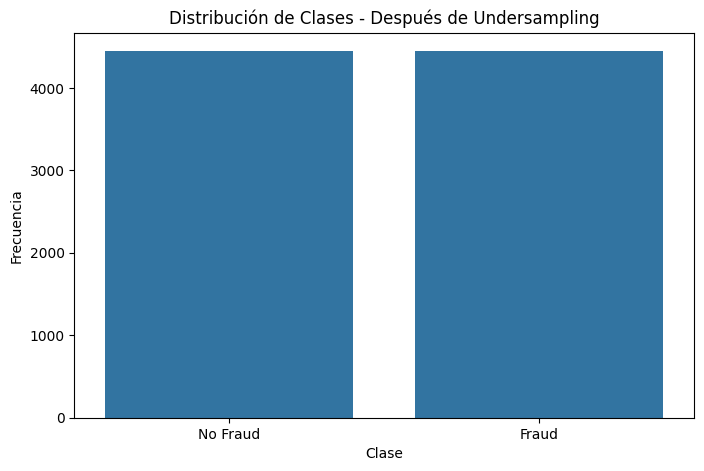


Evaluación en el conjunto de validación para RandomForestClassifier - Semilla 42
  RandomForestClassifier - undersampling (Semilla 42)
    Accuracy: 0.9138720188173598
    Precision: 0.05873116910672608
    Recall: 0.8992852501624431
    F1 Score: 0.11026131293817719
    ROC-AUC: 0.9066221748027068
    Best Parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Modelo guardado como model_kmeans_RandomForestClassifier_undersampling_seed_42.pkl


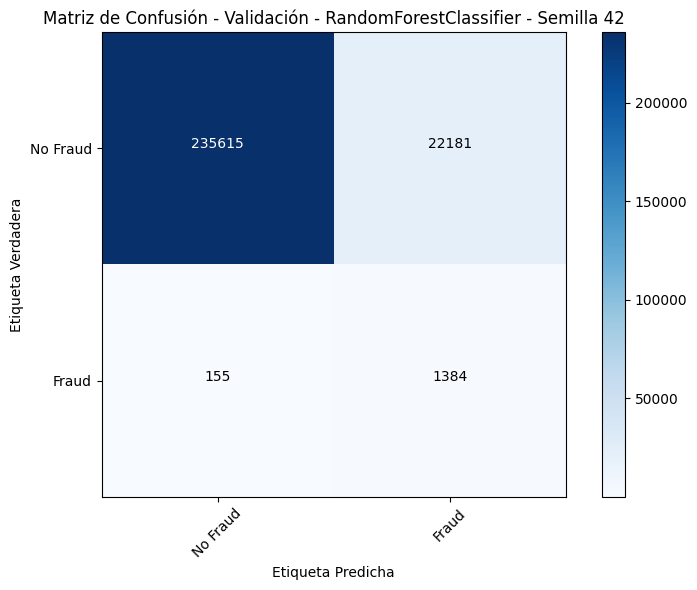

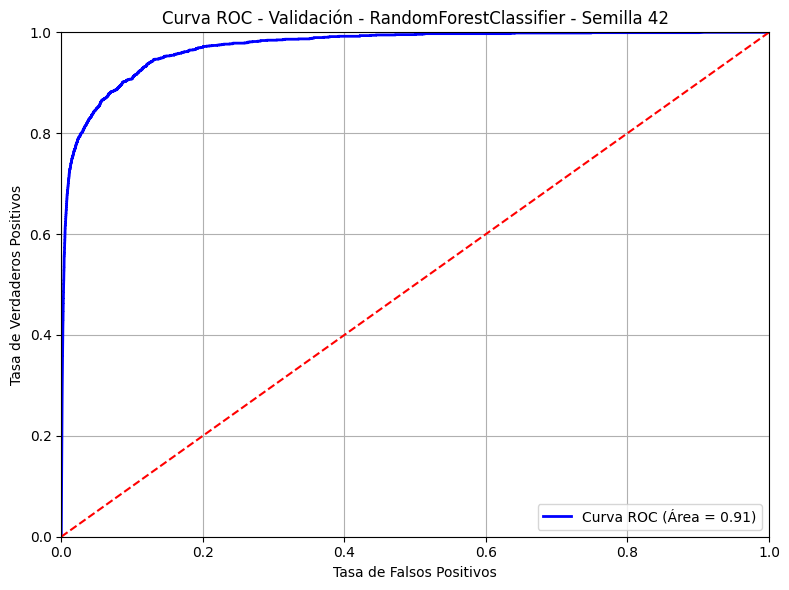


Evaluación final en el conjunto de prueba para RandomForestClassifier - Semilla 42
  RandomForestClassifier - undersampling (Semilla 42)
    Accuracy: 0.9150056876241155
    Precision: 0.058666666666666666
    Recall: 0.8973684210526316
    F1 Score: 0.11013322567622123
    ROC-AUC: 0.9062390463582106
    Best Parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Modelo guardado como model_kmeans_RandomForestClassifier_undersampling_seed_42.pkl


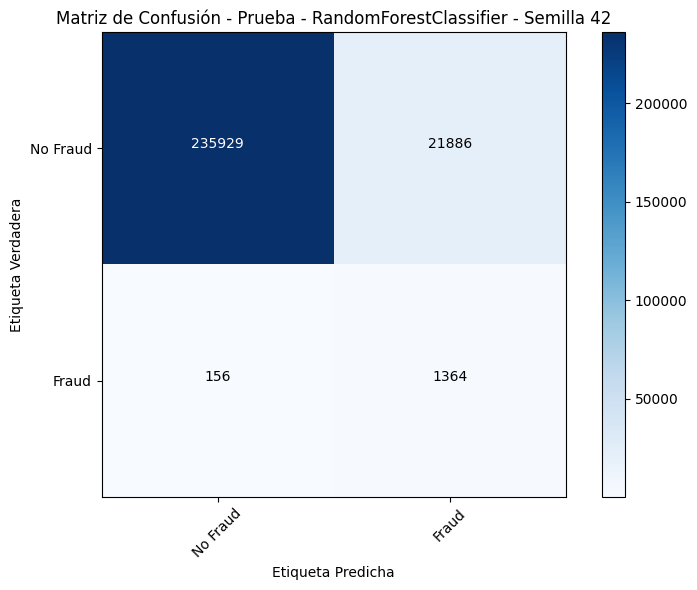

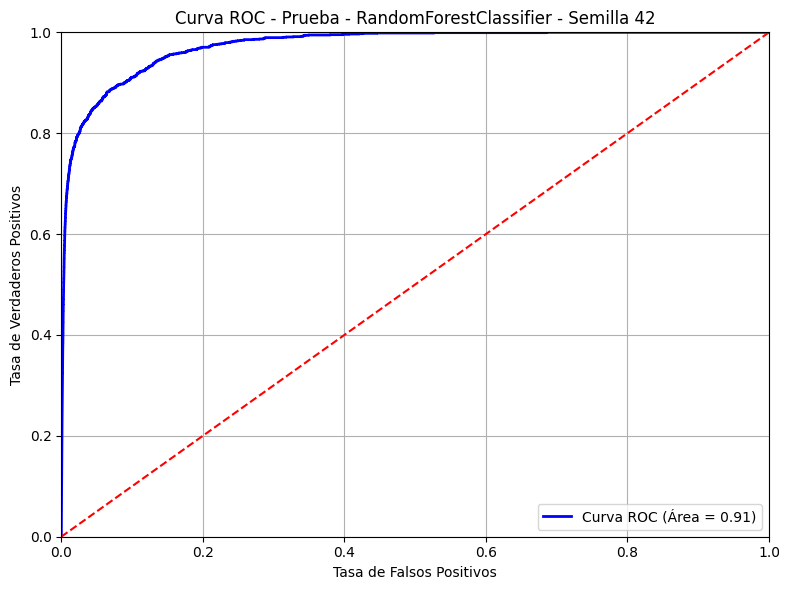

  RandomForestClassifier - undersampling (Semilla 42)
    Accuracy: 0.9150056876241155
    Precision: 0.058666666666666666
    Recall: 0.8973684210526316
    F1 Score: 0.11013322567622123
    ROC-AUC: 0.9062390463582106
    Best Parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Modelo guardado como model_kmeans_RandomForestClassifier_undersampling_seed_42.pkl

--> Iniciando undersampling para LGBMClassifier con semilla 42
Tamaño original de X_train: (778005, 5), y_train: (778005,)


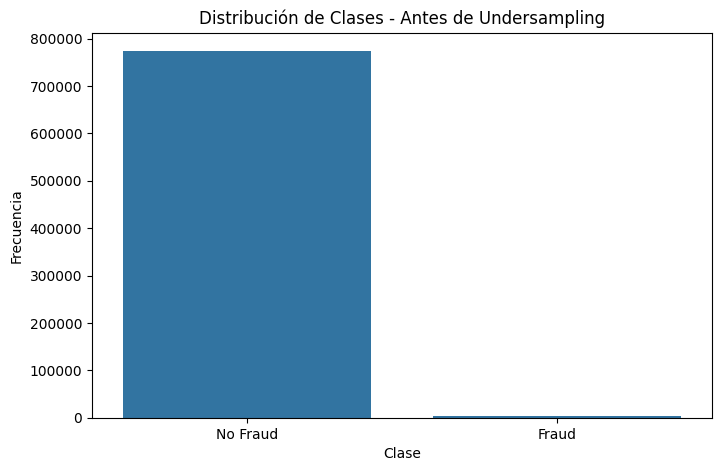

Tamaño después de undersampling de X_train: (8894, 5), y_train: (8894,)


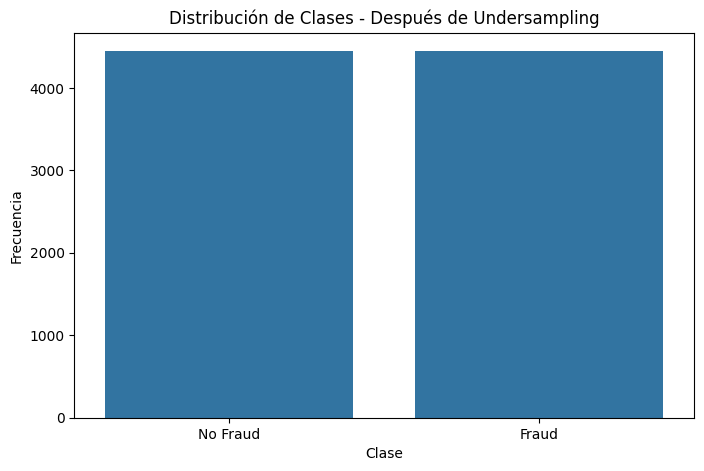

[LightGBM] [Info] Number of positive: 3558, number of negative: 3557
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1025
[LightGBM] [Info] Number of data points in the train set: 7115, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500070 -> initscore=0.000281
[LightGBM] [Info] Start training from score 0.000281
[LightGBM] [Info] Number of positive: 3558, number of negative: 3557
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1025
[LightGBM] [Info] Number of data points in the train set: 7115, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500070 -> initscore=0.000281
[LightGBM] [Info] Start training from score 0.000281
[LightGBM] [Info] Number

c:\Users\Jose Castro\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
c:\Users\Jose Castro\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


  LGBMClassifier - undersampling (Semilla 42)
    Accuracy: 0.911708793645285
    Precision: 0.05714522683918056
    Recall: 0.8953866146848602
    F1 Score: 0.10743382840213621
    ROC-AUC: 0.9035964245358699
    Best Parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31, 'scale_pos_weight': 1}
Modelo guardado como model_kmeans_LGBMClassifier_undersampling_seed_42.pkl


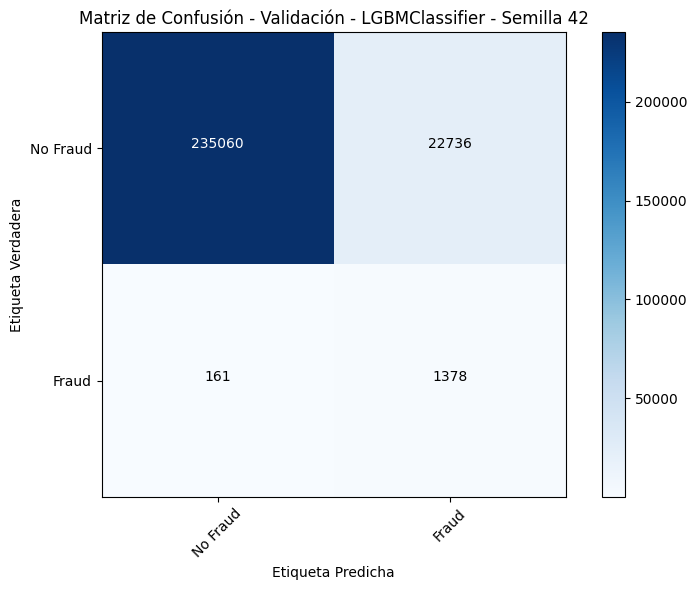

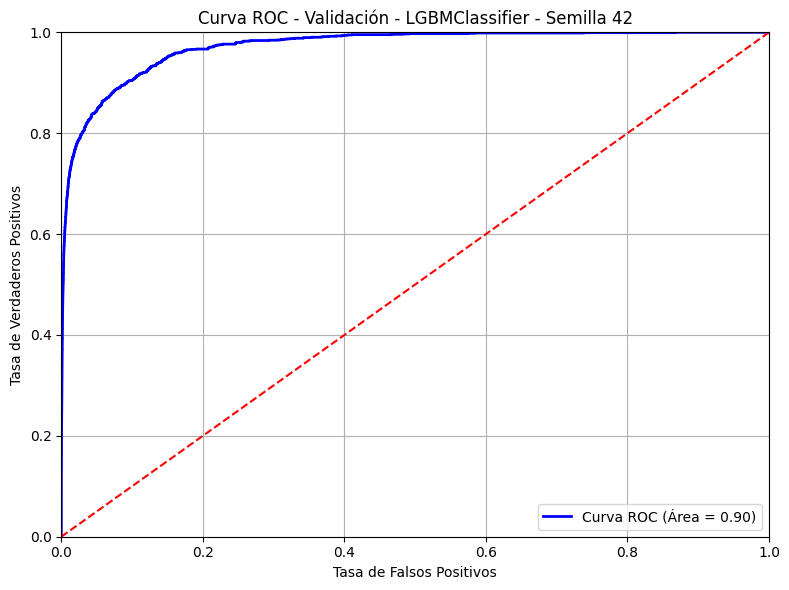


Evaluación final en el conjunto de prueba para LGBMClassifier - Semilla 42


c:\Users\Jose Castro\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
c:\Users\Jose Castro\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


  LGBMClassifier - undersampling (Semilla 42)
    Accuracy: 0.9117974820213238
    Precision: 0.05682384193923294
    Recall: 0.9006578947368421
    F1 Score: 0.10690301421208809
    ROC-AUC: 0.9062605262137172
    Best Parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31, 'scale_pos_weight': 1}
Modelo guardado como model_kmeans_LGBMClassifier_undersampling_seed_42.pkl


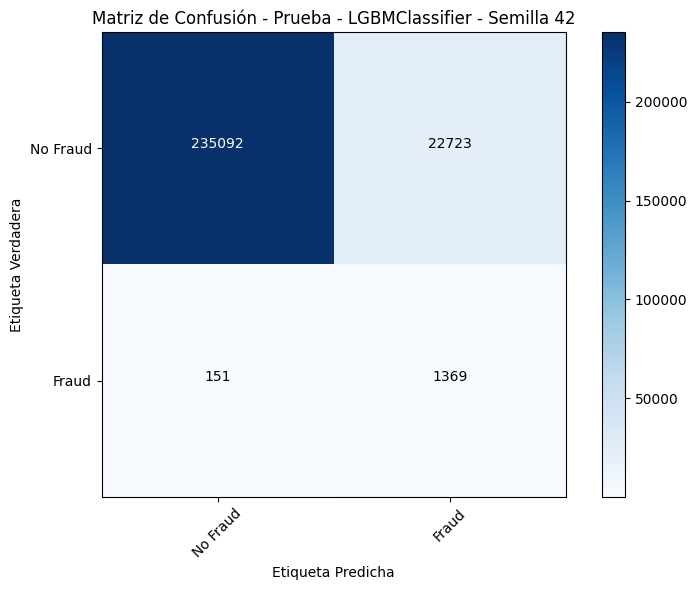

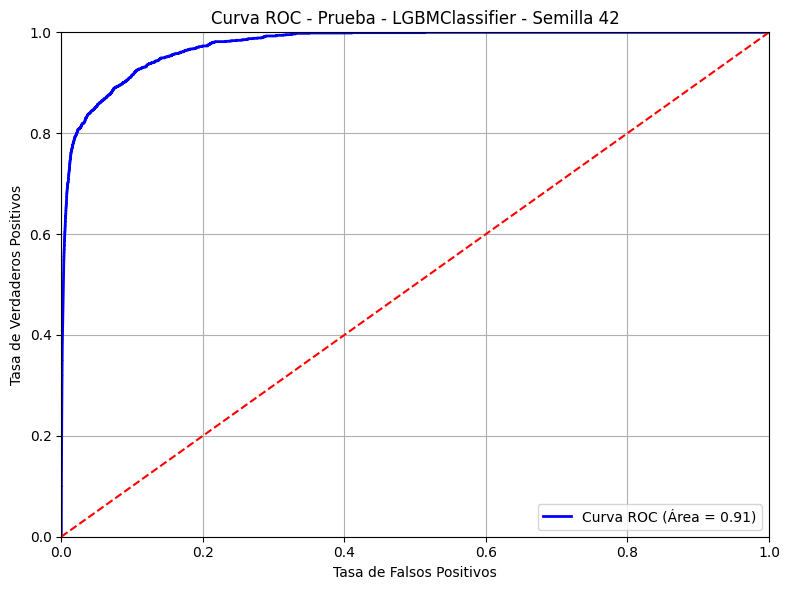

  LGBMClassifier - undersampling (Semilla 42)
    Accuracy: 0.9117974820213238
    Precision: 0.05682384193923294
    Recall: 0.9006578947368421
    F1 Score: 0.10690301421208809
    ROC-AUC: 0.9062605262137172
    Best Parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31, 'scale_pos_weight': 1}
Modelo guardado como model_kmeans_LGBMClassifier_undersampling_seed_42.pkl

--> Iniciando undersampling para XGBClassifier con semilla 42
Tamaño original de X_train: (778005, 5), y_train: (778005,)


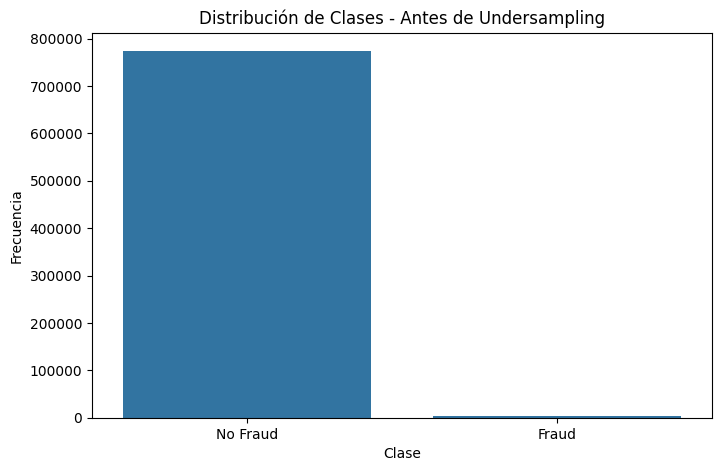

Tamaño después de undersampling de X_train: (8894, 5), y_train: (8894,)


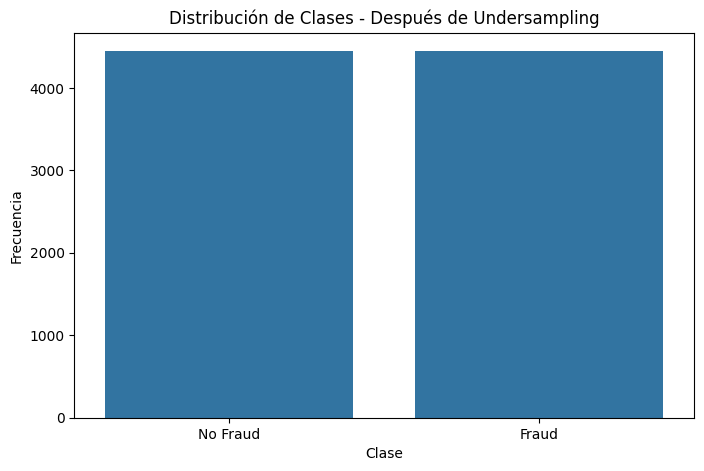


Evaluación en el conjunto de validación para XGBClassifier - Semilla 42
  XGBClassifier - undersampling (Semilla 42)
    Accuracy: 0.9130082711550697
    Precision: 0.05810384696237124
    Recall: 0.8979857050032488
    F1 Score: 0.10914547464855473
    ROC-AUC: 0.9055418292118915
    Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1}
Modelo guardado como model_kmeans_XGBClassifier_undersampling_seed_42.pkl


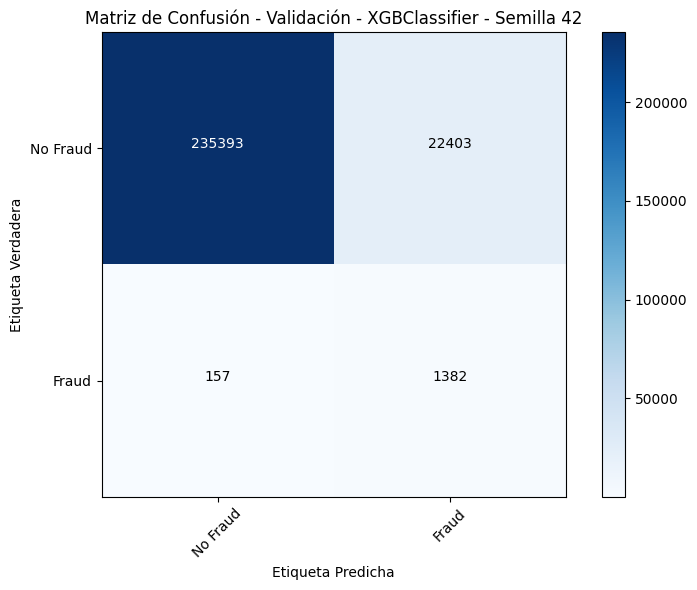

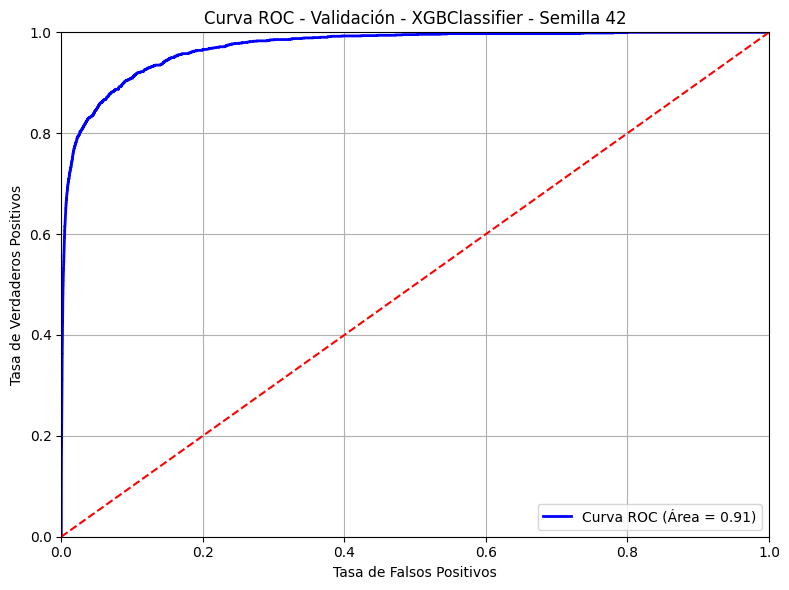


Evaluación final en el conjunto de prueba para XGBClassifier - Semilla 42
  XGBClassifier - undersampling (Semilla 42)
    Accuracy: 0.9138450267029132
    Precision: 0.058179503500954806
    Recall: 0.9019736842105263
    F1 Score: 0.10930835160454455
    ROC-AUC: 0.9079443503960919
    Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1}
Modelo guardado como model_kmeans_XGBClassifier_undersampling_seed_42.pkl


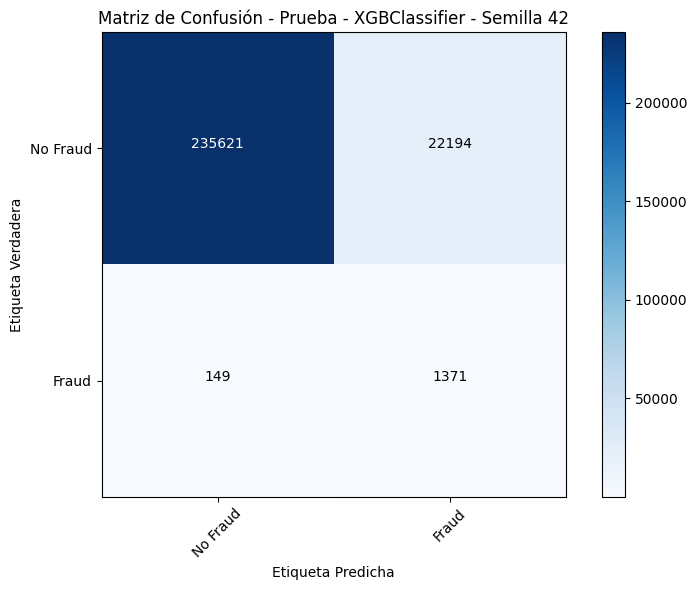

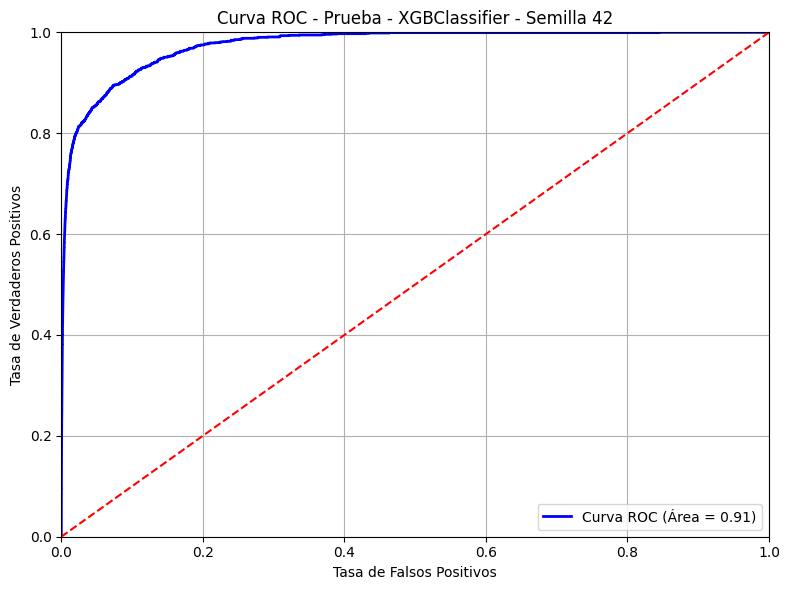

  XGBClassifier - undersampling (Semilla 42)
    Accuracy: 0.9138450267029132
    Precision: 0.058179503500954806
    Recall: 0.9019736842105263
    F1 Score: 0.10930835160454455
    ROC-AUC: 0.9079443503960919
    Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1}
Modelo guardado como model_kmeans_XGBClassifier_undersampling_seed_42.pkl

--> Iniciando undersampling para CatBoostClassifier con semilla 42
Tamaño original de X_train: (778005, 5), y_train: (778005,)


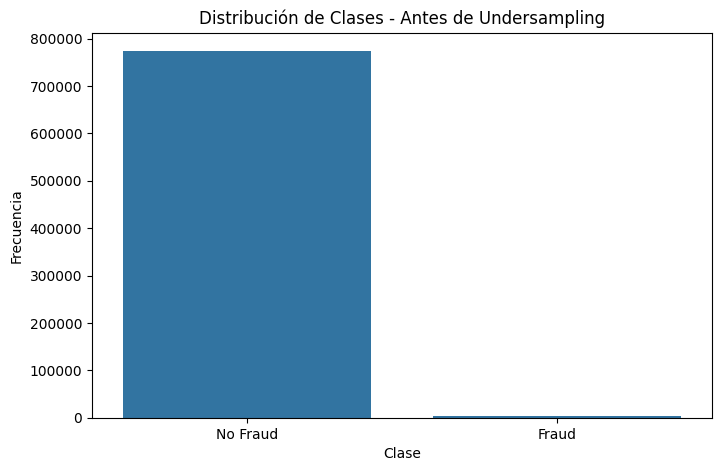

Tamaño después de undersampling de X_train: (8894, 5), y_train: (8894,)


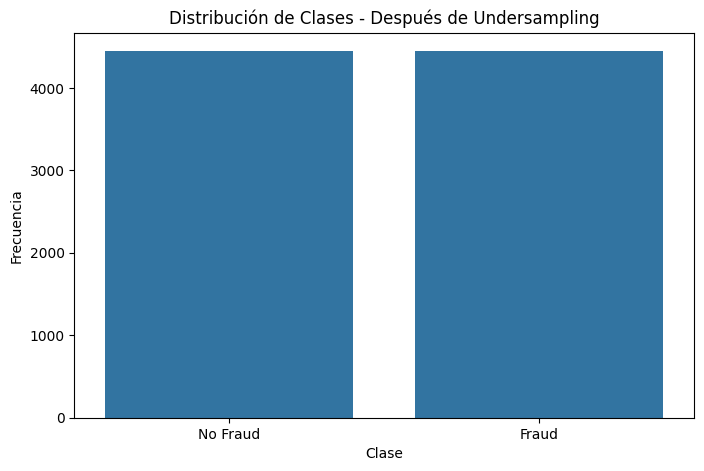


Evaluación en el conjunto de validación para CatBoostClassifier - Semilla 42
  CatBoostClassifier - undersampling (Semilla 42)
    Accuracy: 0.9119902828387992
    Precision: 0.05735557126814458
    Recall: 0.8960363872644574
    F1 Score: 0.10781017903213197
    ROC-AUC: 0.9040609561266041
    Best Parameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Modelo guardado como model_kmeans_CatBoostClassifier_undersampling_seed_42.pkl


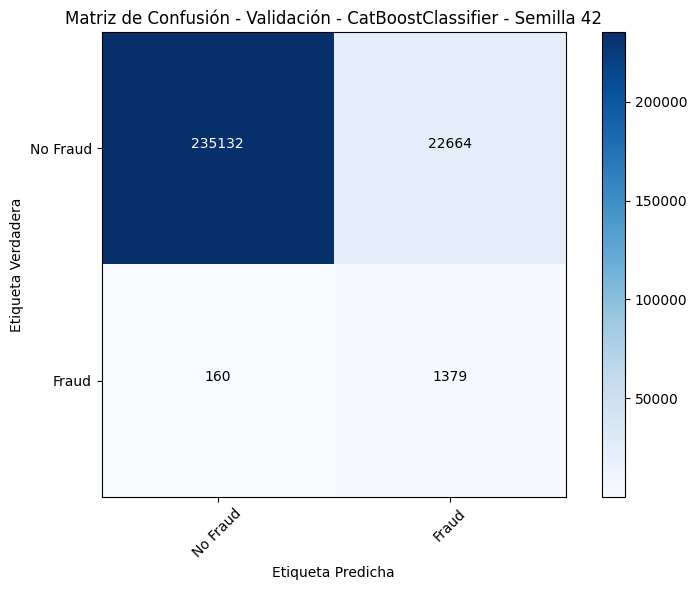

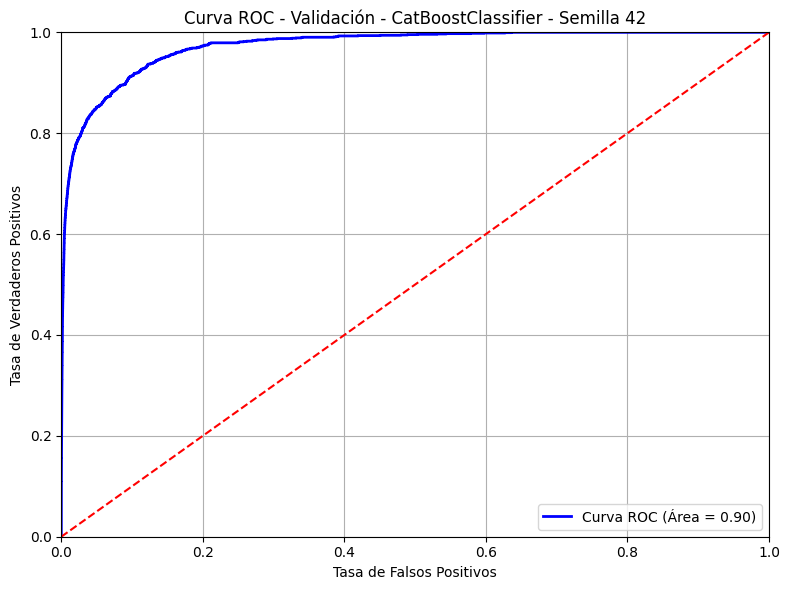


Evaluación final en el conjunto de prueba para CatBoostClassifier - Semilla 42
  CatBoostClassifier - undersampling (Semilla 42)
    Accuracy: 0.9130044151387202
    Precision: 0.05790645879732739
    Recall: 0.906578947368421
    F1 Score: 0.10885965951732038
    ROC-AUC: 0.9098106225700396
    Best Parameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Modelo guardado como model_kmeans_CatBoostClassifier_undersampling_seed_42.pkl


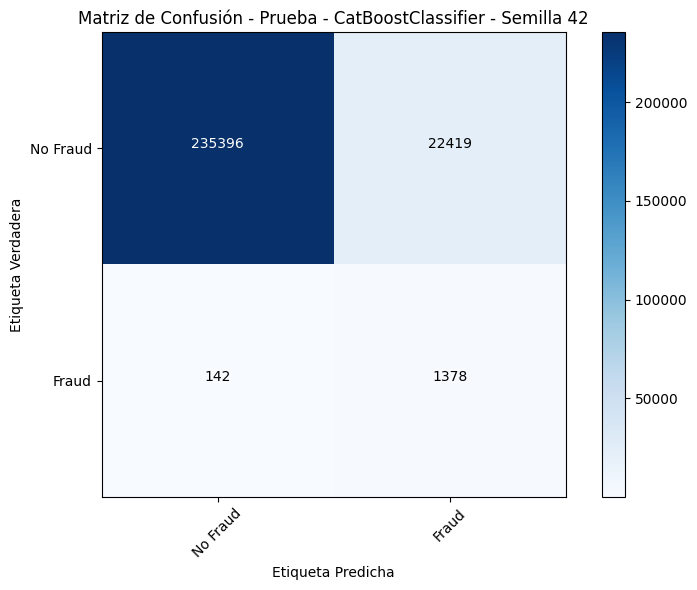

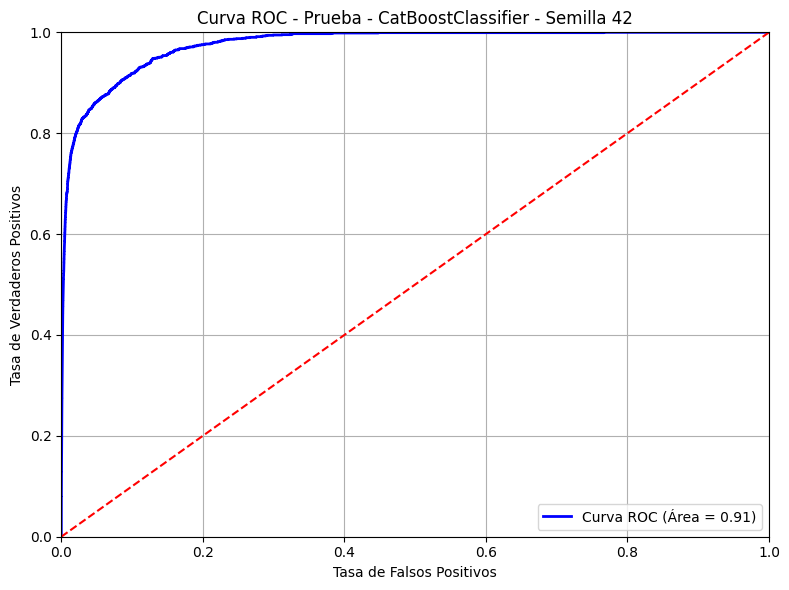

  CatBoostClassifier - undersampling (Semilla 42)
    Accuracy: 0.9130044151387202
    Precision: 0.05790645879732739
    Recall: 0.906578947368421
    F1 Score: 0.10885965951732038
    ROC-AUC: 0.9098106225700396
    Best Parameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Modelo guardado como model_kmeans_CatBoostClassifier_undersampling_seed_42.pkl


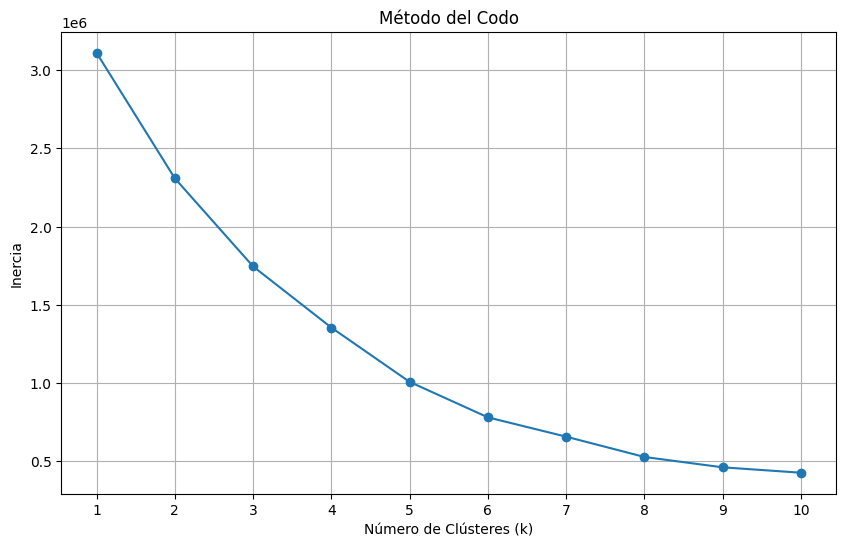


--> Iniciando undersampling para LogisticRegression con semilla 15
Tamaño original de X_train: (778005, 5), y_train: (778005,)


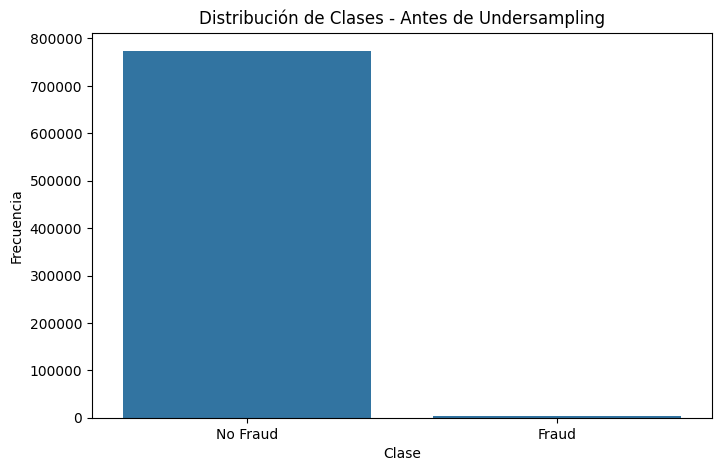

Tamaño después de undersampling de X_train: (9042, 5), y_train: (9042,)


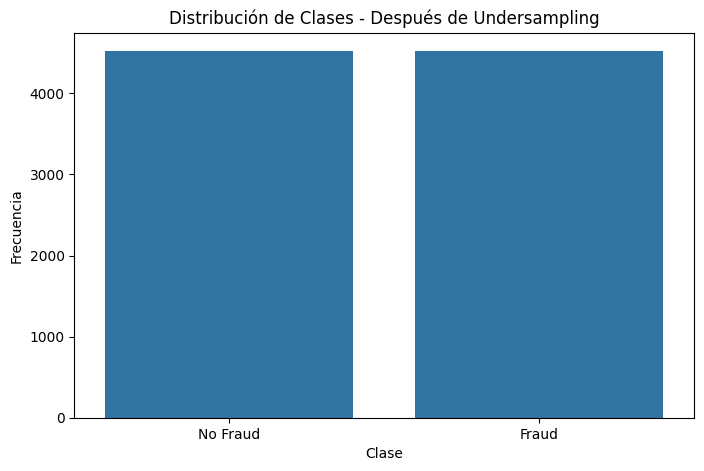


Evaluación en el conjunto de validación para LogisticRegression - Semilla 15
  LogisticRegression - undersampling (Semilla 15)
    Accuracy: 0.9513023695220467
    Precision: 0.08203329103530642
    Recall: 0.7685314685314686
    F1 Score: 0.14824307007486343
    ROC-AUC: 0.8604236218600034
    Best Parameters: {'C': 0.1}
Modelo guardado como model_kmeans_LogisticRegression_undersampling_seed_15.pkl


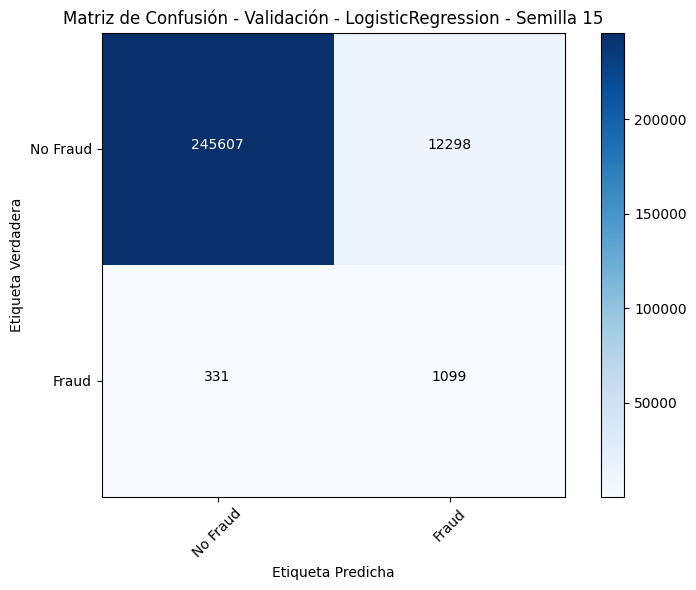

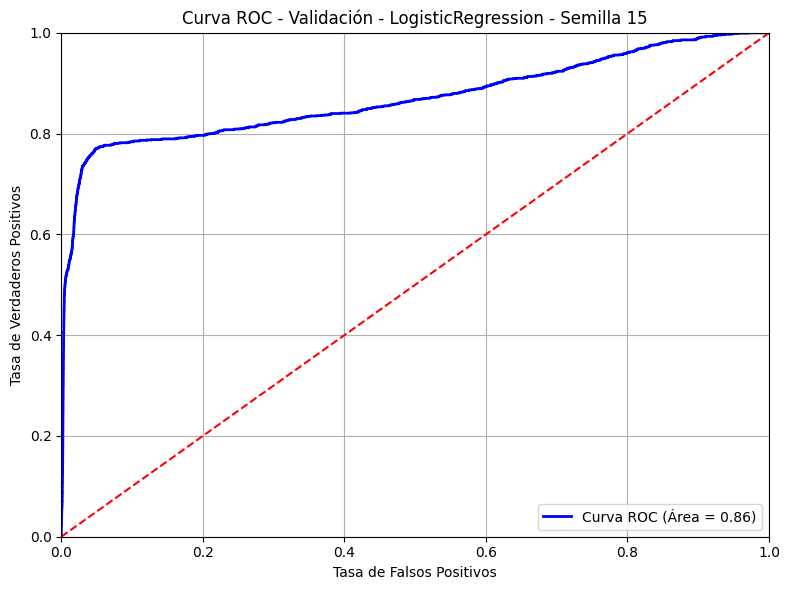


Evaluación final en el conjunto de prueba para LogisticRegression - Semilla 15
  LogisticRegression - undersampling (Semilla 15)
    Accuracy: 0.9505118861703974
    Precision: 0.09012282869394578
    Recall: 0.797427652733119
    F1 Score: 0.16194331983805668
    ROC-AUC: 0.8744314925935748
    Best Parameters: {'C': 0.1}
Modelo guardado como model_kmeans_LogisticRegression_undersampling_seed_15.pkl


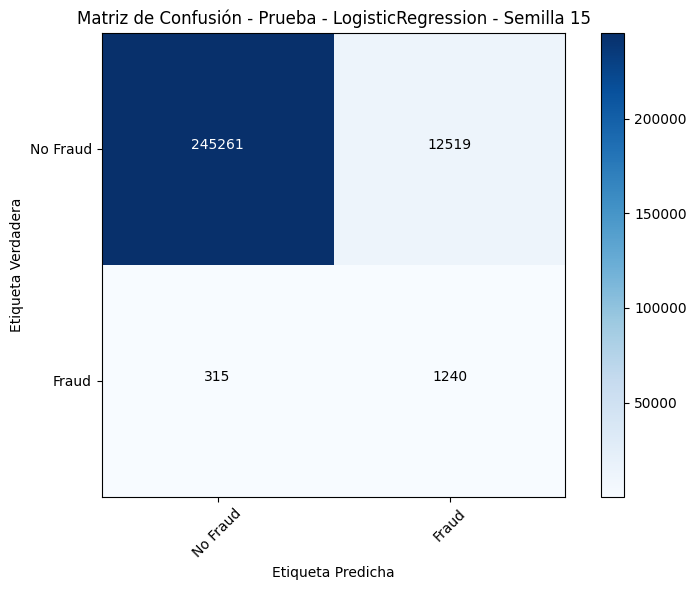

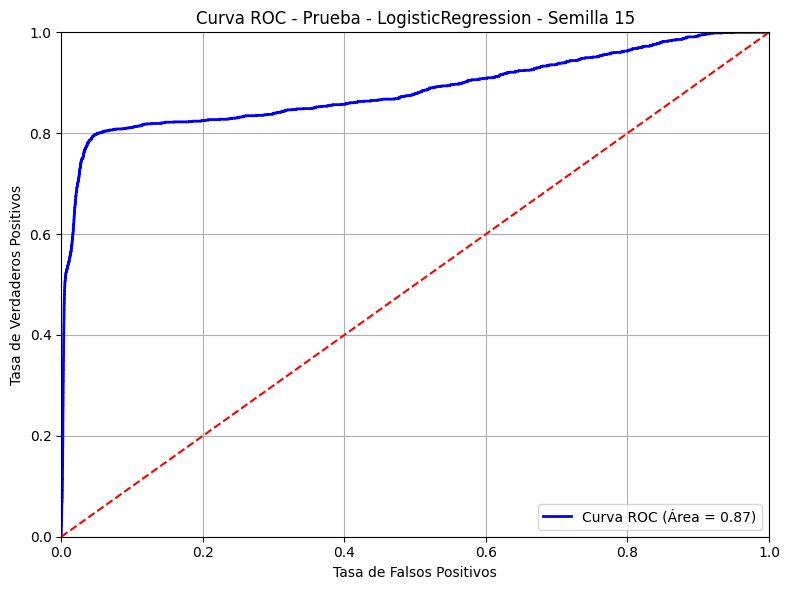

  LogisticRegression - undersampling (Semilla 15)
    Accuracy: 0.9505118861703974
    Precision: 0.09012282869394578
    Recall: 0.797427652733119
    F1 Score: 0.16194331983805668
    ROC-AUC: 0.8744314925935748
    Best Parameters: {'C': 0.1}
Modelo guardado como model_kmeans_LogisticRegression_undersampling_seed_15.pkl

--> Iniciando undersampling para DecisionTreeClassifier con semilla 15
Tamaño original de X_train: (778005, 5), y_train: (778005,)


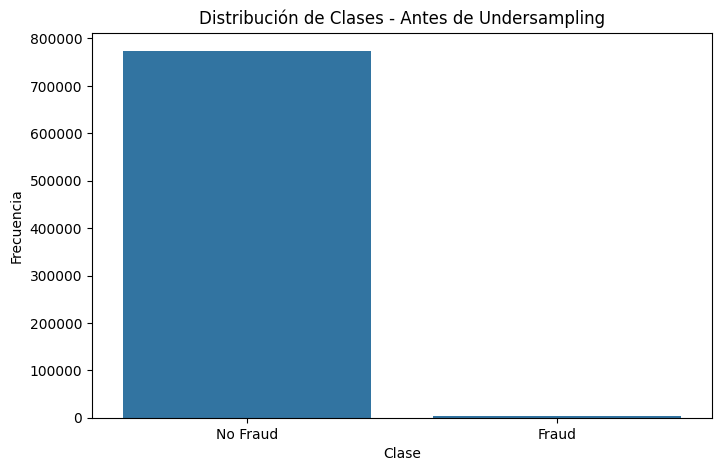

Tamaño después de undersampling de X_train: (9042, 5), y_train: (9042,)


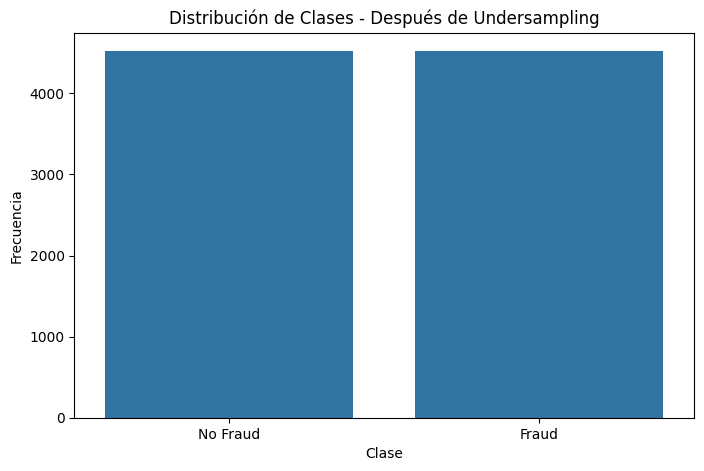


Evaluación en el conjunto de validación para DecisionTreeClassifier - Semilla 15
  DecisionTreeClassifier - undersampling (Semilla 15)
    Accuracy: 0.8943682881215417
    Precision: 0.045384507634122426
    Recall: 0.9062937062937063
    F1 Score: 0.0864403388247849
    ROC-AUC: 0.900297935909886
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Modelo guardado como model_kmeans_DecisionTreeClassifier_undersampling_seed_15.pkl


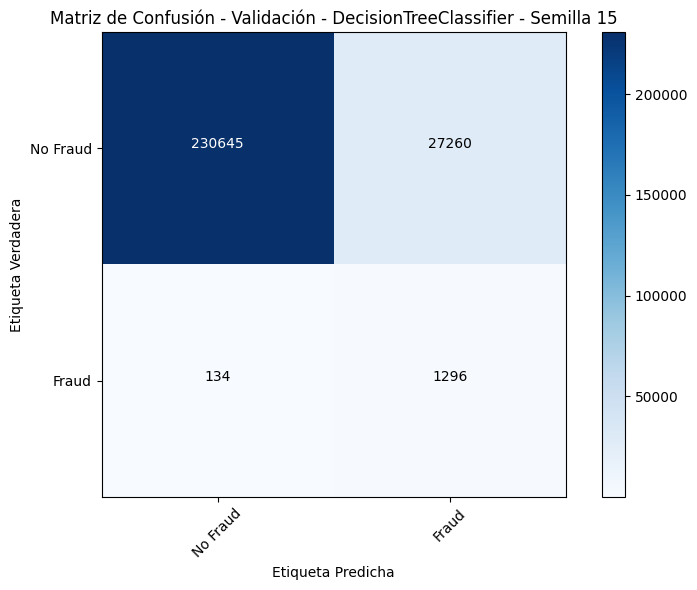

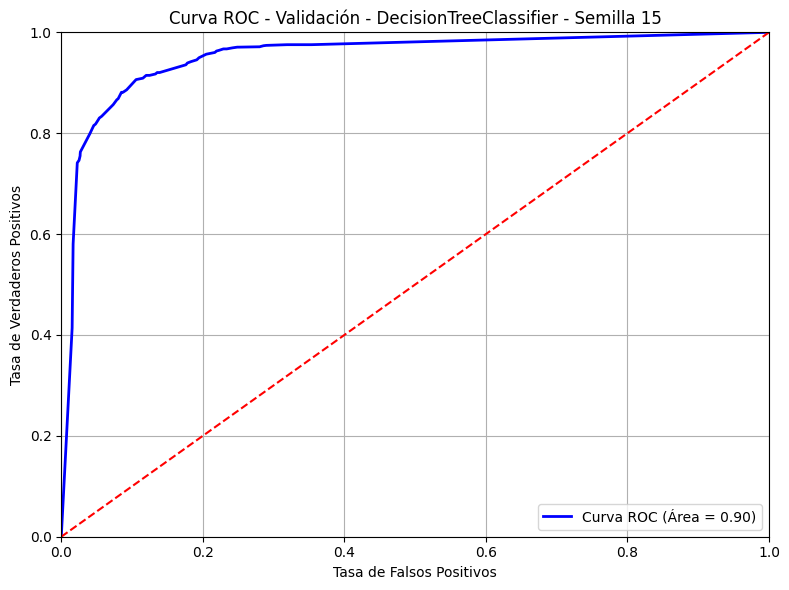


Evaluación final en el conjunto de prueba para DecisionTreeClassifier - Semilla 15
  DecisionTreeClassifier - undersampling (Semilla 15)
    Accuracy: 0.8940867989280274
    Precision: 0.04926245477317005
    Recall: 0.9106109324758842
    F1 Score: 0.09346843130136308
    ROC-AUC: 0.9022990266382835
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Modelo guardado como model_kmeans_DecisionTreeClassifier_undersampling_seed_15.pkl


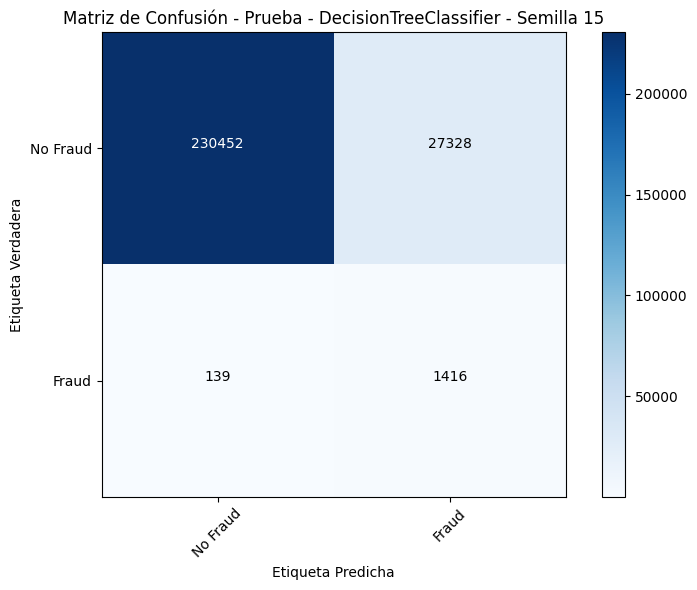

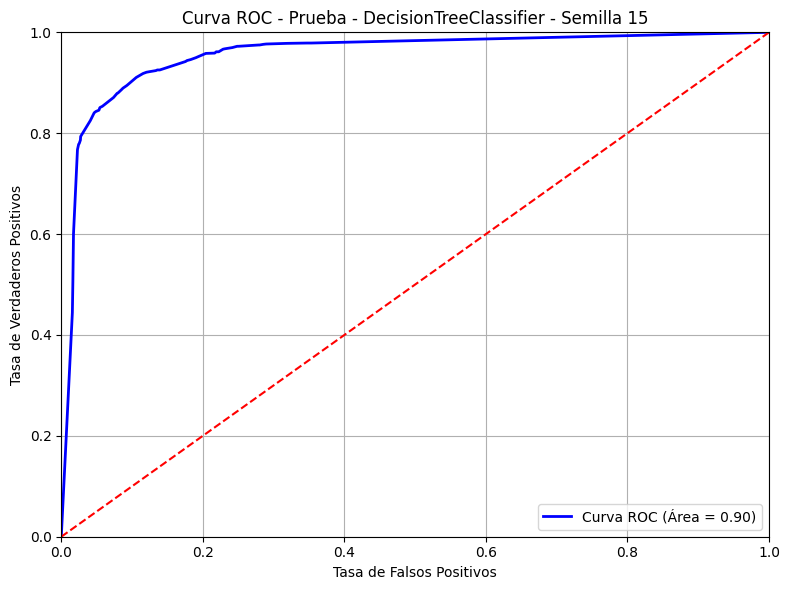

  DecisionTreeClassifier - undersampling (Semilla 15)
    Accuracy: 0.8940867989280274
    Precision: 0.04926245477317005
    Recall: 0.9106109324758842
    F1 Score: 0.09346843130136308
    ROC-AUC: 0.9022990266382835
    Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Modelo guardado como model_kmeans_DecisionTreeClassifier_undersampling_seed_15.pkl

--> Iniciando undersampling para RandomForestClassifier con semilla 15
Tamaño original de X_train: (778005, 5), y_train: (778005,)


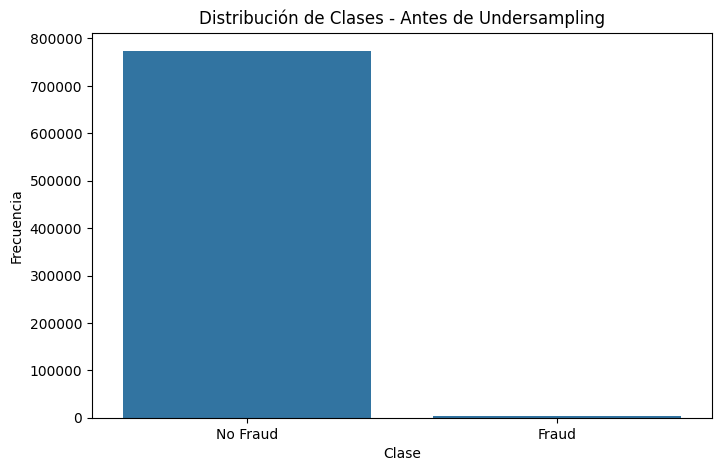

Tamaño después de undersampling de X_train: (9042, 5), y_train: (9042,)


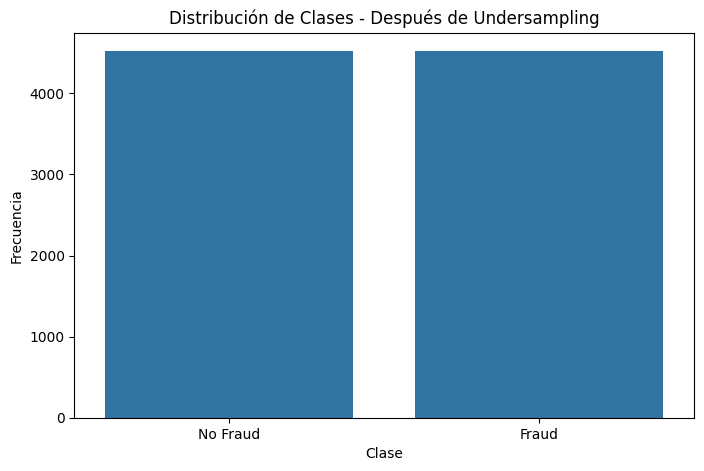

In [ ]:
models_and_params = [
    (LogisticRegression(max_iter=2000), {'C': [0.001, 0.01, 0.1, 1, 10, 100]}),
    (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
    (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
    # Modelos con scale_pos_weight
    (LGBMClassifier(), {'num_leaves': [31, 50, 100], 'max_depth': [-1, 10, 20], 'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [100, 200], 'scale_pos_weight': [1, 10, 20]}),
    (XGBClassifier(eval_metric='mlogloss', use_label_encoder=False), {'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [100, 200], 'scale_pos_weight': [1, 10, 20]}),
    (CatBoostClassifier(silent=True), {'depth': [4, 6, 8], 'learning_rate': [0.01, 0.1], 'iterations': [100, 200]})
]

for seed in seed_list:
    results_by_seed[seed] = {}

    # Dividir en conjunto de entrenamiento y prueba primero
    X_train_val, X_test, y_train_val, y_test = train_test_split(features, target, test_size=0.2, random_state=seed)
    
    # Luego, dividir el conjunto de entrenamiento en entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=seed)

    # Transformar los conjuntos de datos
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_val_transformed = preprocessor.transform(X_val)
    X_test_transformed = preprocessor.transform(X_test)

    # ------------------- CLUSTERING CON K-MEANS -------------------------
    # 1. Determinar el número óptimo de clústeres en el conjunto de entrenamiento
    inertia = []
    k_values = range(1, 11)  # Probar con 1 a 10 clústeres

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=seed)
        kmeans.fit(X_train_transformed)
        inertia.append(kmeans.inertia_)

    # Graficar el método del codo
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, inertia, marker='o')
    plt.title('Método del Codo')
    plt.xlabel('Número de Clústeres (k)')
    plt.ylabel('Inercia')
    plt.xticks(k_values)
    plt.grid()
    plt.show()

    # 2. Aplicar K-means con el número óptimo de clústeres
    k_optimo = 6  # Asignar el valor óptimo basado en el método del codo
    kmeans_final = KMeans(n_clusters=k_optimo, random_state=seed)

    # Obtener clústeres para los conjuntos de entrenamiento, validación y prueba
    clusters_train = kmeans_final.fit_predict(X_train_transformed)
    clusters_val = kmeans_final.predict(X_val_transformed)
    clusters_test = kmeans_final.predict(X_test_transformed)

    # Convertir los clusters en matrices dispersas
    clusters_train = csr_matrix(clusters_train.reshape(-1, 1))
    clusters_val = csr_matrix(clusters_val.reshape(-1, 1))
    clusters_test = csr_matrix(clusters_test.reshape(-1, 1))

    # Agregar los clústeres como una nueva característica
    X_train_transformed = hstack([X_train_transformed, clusters_train])
    X_val_transformed = hstack([X_val_transformed, clusters_val])
    X_test_transformed = hstack([X_test_transformed, clusters_test])

    # ------------------- EVALUACIÓN DE MODELOS -------------------------
    for model_class, param_grid in models_and_params:
        model_name = model_class.__class__.__name__

        if model_name == 'CatBoostClassifier':
            model_class = CatBoostClassifier(silent=True, random_seed=seed)
            param_grid.pop("random_seed", None)

        # Evaluación con undersampling
        results_undersampling = grid_search_with_and_without_balance(
            model_class, param_grid, X_train_transformed, y_train,
            X_val_transformed, y_val, X_test_transformed, y_test,
            sampler=SamplingMethod.UNDERSAMPLING, random_seed=seed, balance_type='undersampling'
        )
        print_results(results_undersampling, model_name, 'undersampling', seed)